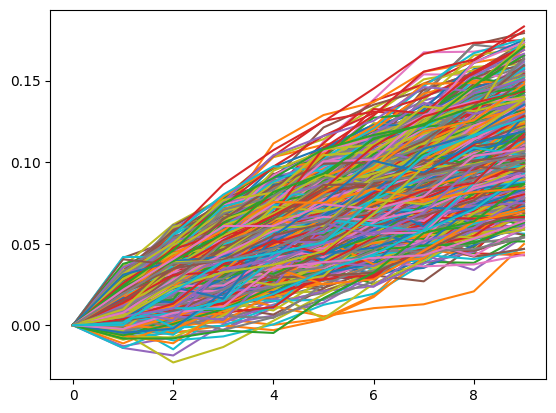

$x_t = x_{t-1} + \theta \cdot (\mu - x_{t-1})\cdot dt + \sigma \cdot N_{dist}$

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.019429,0.052402,0.063065,0.082014,0.082741,0.089606,0.104530,0.105767,0.125708
1,0.0,0.004837,0.028111,0.045003,0.068017,0.073435,0.097371,0.099431,0.105284,0.122935
2,0.0,0.007100,0.036326,0.054890,0.072885,0.078714,0.107342,0.107089,0.119871,0.127934
3,0.0,0.008064,0.020047,0.039624,0.038517,0.041691,0.062846,0.077289,0.091021,0.092411
4,0.0,0.016288,0.032609,0.054078,0.070700,0.078622,0.096493,0.117515,0.130474,0.156739
...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.021157,0.034757,0.040093,0.055049,0.062274,0.078811,0.092611,0.100991,0.103711
996,0.0,0.021717,0.040586,0.060814,0.060869,0.074135,0.071136,0.078996,0.103680,0.108224
997,0.0,0.019116,0.037888,0.039361,0.047026,0.059516,0.088477,0.091220,0.098308,0.104696
998,0.0,0.005335,0.023004,0.032572,0.037077,0.045430,0.068166,0.097188,0.117666,0.138410


In [2]:
#import math
import random
import numpy as np #kan erstattes
import numpy.random as npr
import numpy.linalg as npl
import pandas as pd #kan erstattes
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# numpy
#import numpy as np
#from numpy.random import default_rng
#rng = default_rng()

# import functions
#from numpy import log, log10, sin, cos, exp, sqrt, pi

# plotting
#import matplotlib.pyplot as plt
#import matplotlib.ticker as mticker

# progress bar
#from tqdm.notebook import tqdm
#from tqdm import trange
#from time import sleep
#from tqdm import tqdm

# warnings
#import warnings
#warnings.simplefilter('ignore')

class simulation():
    """
    thanks to 
    @JChonpca_Huang
    @Jonas_hal
    @Anton_vorobets
    """

    def __init__(self, runs = 5, timeframe = 30, steps = 1, solver = "Euler"):

        self.runs = runs
        self.timeframe = timeframe
        self.steps = steps
        self.size = [self.runs, self.timeframe*self.steps]
        self.X0 = 1
        self.dt = 1/self.timeframe
        
        self.equation = ""
        self.solver = solver
        
        self.participants = 0
        self.mu = 1
        self.rho = 0.25
        self.r = 0.05
        self.sigma = 0.25
        self.kappa = 0.4
        self.theta = 0.4
        self.corr_mat = np.zeros((2, 2))
        self.corr_mat[0, :] = [1.0, self.rho]
        self.corr_mat[1, :] = [self.rho, 1.0]
        self.cho_mat = np.linalg.cholesky(self.corr_mat)
        self.vol0 = 0.25
        
        self.lam = 1
        self.jump_mean = 1
        self.jump_std = 0.25
        
        clm = []
        for i in range(0, self.timeframe*self.steps):
            clm.append(i)
        
        paths = []
        for i in range(0, runs):
            path = [0]

            for j in range(1, (self.timeframe*self.steps)):
                path.append(0)
            paths.append(path)
        self.paths = pd.DataFrame(paths, columns = clm)
        self.paths = self.paths.astype('float64')
        
        # Generate the Gaussian noise
        self.rw_paths = pd.DataFrame(np.random.normal(loc=0, scale=np.sqrt(1.0), size = self.size)) #dW
        self.dw = self.rw_paths
        self.dw_2 = (self.dw**2 - 1.0) * 0.5
        # Generate the Poissonian Jumps
        self.poss_paths = pd.DataFrame(np.random.poisson(lam=1 * 1.0, size = self.size)) #dJ
        self.dJ = self.poss_paths

    #hvis print() så hvad?
    
    #def __str__(self):
        #return f"runs = {self.runs}, timeframe = {self.timeframe}, steps = {self.steps}"
    
    #print equations
    
    def printeq(self):
        try:
            if self.equation2:
                display(Markdown(self.equation))
                display(Markdown(self.equation2))
        except AttributeError:
            display(Markdown(self.equation))
    
    #set process parameters
    
    def set_parameters(self, fluid = False, runs = 10, timeframe = 30, value = 100, participants = 10, mu = 1, rho = 0.25, r = 0.05, sigma = 0.25, kappa = 0.4, theta = 0.4, vol0 = 0.25, lam = 1, jump_mean = 1, jump_std = 0.25):
        if fluid == True:
            self.runs = int(input('redefine runs:'))
            self.timeframe = int(input('redefine timeframe:'))
            self.X0 = int(input('redefine start-value:'))
            self.participants = int(input('define number of participants:'))
            self.dt = 1/self.timeframe
            
            self.rho = float(input('set rho:'))
            self.r = float(input('set risk-free rate:'))
            
            self.mu = float(input('mu:'))
            self.sigma = float(input('sigma:'))
            self.kappa = float(input('longterm volatility (Theta):'))
            self.theta = float(input('return-rate for volatility (Kappa):'))
            self.corr_mat = np.zeros((2, 2))
            self.corr_mat[0, :] = [1.0, self.rho]
            self.corr_mat[1, :] = [self.rho, 1.0]
            self.cho_mat = np.linalg.cholesky(self.corr_mat)
            self.vol0 = float(input('start volatility:'))
            
            self.lam = float(input('lambda:'))
            self.jump_mean = float(input('jump mean size:'))
            self.jump_std = float(input('jump standard deviation:'))
            
        if fluid == False:    
            self.runs = runs
            self.timeframe = timeframe
            self.dt = 1/self.timeframe
            
            self.X0 = value
            self.participants = participants
            
            self.rho = rho
            self.r = r
            
            self.mu = mu
            self.sigma = sigma
            self.kappa = kappa
            self.theta = theta
            self.corr_mat = np.zeros((2, 2))
            self.corr_mat[0, :] = [1.0, self.rho]
            self.corr_mat[1, :] = [self.rho, 1.0]
            self.cho_mat = np.linalg.cholesky(self.corr_mat)
            self.vol0 = vol0
            
            self.lam = lam
            self.jump_mean = jump_mean
            self.jump_std = jump_std
      
    
    
    
    
    
    #Run statistics?
    
    def stats(self):
        self.stat_df = pd.DataFrame(index = self.paths.columns, columns = ['means', 'stds', 'var5', 'cvar5'])
        for i in range(len(self.paths.columns)):
            self.stat_df['means'][i] = np.mean(self.paths[i])
            self.stat_df['stds'][i] = np.std(self.paths[i])
            self.stat_df['var5'][i] = np.mean(self.paths[i])
            self.stat_df['cvar5'][i] = np.mean(self.paths[i])
        return(self.stat_df.T)
    
    #run plots
    
    def plot(self):
        for i in range(len(self.paths)):
            plt.plot(self.paths.columns, self.paths.loc[i])
        plt.show()

        
        
        
        
        
        
    #processes
    
    def random_walk(self):
        self.paths = pd.DataFrame(np.random.normal(loc=0, scale=np.sqrt(1.0), size=[self.runs, self.timeframe]))
    
    
    
    
    #def geometric_2(self):
        #elif method.find("Geometric Brownian") != -1 or method.find("geometric brownian") != -1 or method.find("Geometric brownian") != -1 or method.find("geometric Brownian") != -1:
        #S = np.zeros((timeframe + 1, iterations))
        #S[0] = x0
        #for t in range(1, timeframe + 1):
            #S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(iterations))
        #plt.plot(S[:, :10], lw=1.5)
        #plt.ylabel('index level')
        #plt.grid(True)
        #plt.show()
        #result = "Geometric brownian motion process"
        #print(result)
    
        
    def geometric_brownian_motion(self):
        self.equation = r'$x_t = x_{t-1} + \theta \cdot (\mu - x_{t-1})\cdot dt + \sigma \cdot N_{dist}$'
        std_dt = ( self.sigma**2 /(2*self.kappa) * (1-2.7182818**(-2*self.kappa*self.dt)) )**(1/2)
        
        for i in range(0,len(self.paths)):
            for j in range(1, len(self.paths.columns)):
                self.paths.iloc[i,j] = self.mu + np.exp(-self.kappa*self.dt) * (self.paths.iloc[i,j-1]-self.mu) + std_dt * self.rw_paths.iloc[i,j]  
    
    
    def jump_diffusion(self, solver = "Euler"):
        self.equation = r'$ \mathrm{d} X(t) = a(x,t)\;\mathrm{d} t + b(x,t)\;\mathrm{d} W(t)+ \xi\;\mathrm{d} J(t) $'
        a = lambda x: -2*x
        b = lambda x: 1
        b_prime = lambda x: 0

        self.solver = solver

        for j in range(0, len(self.paths)):

            for i in range(1, len(self.paths.columns)):

                if solver == 'Euler':

                    self.paths[i][j] = self.paths[i-1][j] + a(self.paths[i-1][j]) * self.dt + b(self.paths[i-1][j]) * self.dw[i][j]

                elif solver == 'Milstein':
                     self.paths[i][j] = self.paths[i-1][j] + a(self.paths[i-1][j]) * self.dt + b(self.paths[i-1][j]) * self.dw[i][j] + b(self.paths[i-1][j]) * b_prime(self.paths[i-1][j]) * self.dw_2[i][j]

                if self.dJ[i][j] > 0.:

                    self.paths[i][j] += np.sum(np.random.normal(0, np.sqrt(0.25), size=self.dJ[i][j]))

    #(time: float, delta_t: float, a: callable, b: callable, xi: float, lamb: float, init: float = None, solver: str = 'Euler', b_prime: callable = None) -> np.ndarray:
        
    # assert and conditions
    #assert time > 0, "Total integration time must be positive"
    #assert delta_t > 0, "Time sampling must be positive"
    #if solver == 'Milstein':
        #assert b_prime != None, "Introduce b'(x) to use the Milstein solver"
        #assert callable(b_prime) == True, "b'(x) must be a function"

    #assert callable(a) == True, "drift a(x) must be a function"
    #assert callable(b) == True, "diffusion b(x) must be a function"
    #assert isinstance(lamb, int) or isinstance(lamb, float), ("'lamb' is not an"" int or float")
    #assert isinstance(xi, int) or isinstance(xi, float), ("'xi' is not an int " "or float")


    # Define total length of timeseries
    #length = int(time/delta_t)

    # Initialise the array X
    #X = np.zeros(length)

    # randomise initial starting value or use given (after assert)
    #if init is None:
        #X[0] = np.random.normal(loc=0, scale=np.sqrt(delta_t), size=1)
    #else:
        #assert isinstance(init, int) or isinstance(init, float), ("'init' is " "not an int or float")
        #X[0] = float(init)
    
    
    
    def stochastic_volatility(self):
        self.equation = r'$$ V_t = V_{t-1} + \kappa \cdot (\theta - max(V_{t-1},0)) \cdot dt + \sigma \cdot \sqrt{max(V_{t-1},0)} \cdot ( \hat{c} \cdot N_{dist}) \cdot \sqrt{dt} $$'
        self.equation2 = r'$$ S_t = S_{t-1} \cdot e^{r-0.5 \cdot V_t} \cdot dt + \sqrt{V_t} \cdot ( \hat{c} \cdot N_{dist}) \cdot \sqrt{dt} $$'
        ran_num = np.random.standard_normal((2, self.timeframe + 1, self.runs))

        v = np.zeros_like(ran_num[0])
        vh = np.zeros_like(v)

        v[0] = self.vol0
        vh[0] = self.vol0

        for t in range(1, self.timeframe + 1):
            ran = np.dot(self.cho_mat, ran_num[:, t, :])
            vh[t] = (vh[t - 1] + self.kappa * (self.theta - np.maximum(vh[t - 1], 0)) * self.dt + self.sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(self.dt) * ran[1])

        v = np.maximum(vh, 0)

        Sv = np.zeros_like(ran_num[0])
        Sv[0] = self.X0
        for t in range(1, self.timeframe + 1):
            ran = np.dot(self.cho_mat, ran_num[:, t, :])
            Sv[t] = Sv[t - 1] * np.exp((self.r - 0.5 * v[t]) * self.dt + np.sqrt(v[t]) * ran[0] * np.sqrt(self.dt))

        self.paths = pd.DataFrame(Sv).T

    def square_root_diffusion(self, solver = "Euler"):
        """
        :param _print_: must be True or False
        :param x0:      Is set to be 1, unless changed by the user
        :param theta:   Is set to be 0.5, unless changed by the user
        :param mu:      Is set to be 1, unless changed by the user
        :param sigma:   Is set to be 0.25, unless changed by the user.
        """
        self.solver = solver
        walkh = np.zeros((self.timeframe,self.runs))
        walks = np.zeros((self.timeframe,self.runs))
        walkh[0] = self.X0
        walks[0] = self.X0
        self.dt = 1.0

        if self.solver.lower() == "euler":
            self.equation = r'$x_t = x_{t-1} + \theta \cdot (\mu - max(x_{t-1}, 0)) \cdot dt + \sigma \cdot \sqrt {max(x_{t-1}, 0))} \cdot \sqrt{dt} \cdot N_{dist}$'
            
            for t in range(1, self.timeframe):
                walkh[t] = (walkh[t - 1] + self.theta * (self.mu - np.maximum(walkh[t - 1], 0)) * self.dt + self.sigma * np.sqrt(np.maximum(walkh[t - 1], 0)) * np.sqrt(self.dt) * np.random.standard_normal(self.runs))
            
            walks = np.maximum(walkh, 0)
            
        elif self.solver.lower() == "exact":
            self.equation = r'$x_t = \frac{\sigma^2 \cdot (1 - e^{-\theta \cdot dt})}{(4\theta)} \cdot \chi^2 \left (4 \mu \cdot \frac{\theta}{\sigma^2}, \frac{e^{-\theta \cdot dt}}{\frac{\sigma^2 \cdot (1 - e^{-\theta \cdot dt})}{(4\theta)}} \cdot x_{t-1}  \right )$'
            
            for t in range(1, self.timeframe):
                df = 4 * self.mu * self.theta / self.sigma ** 2
                c = (self.sigma ** 2 * (1 - np.exp(-self.theta * self.dt))) / (4 * self.theta)
                nc = np.exp(-self.theta * self.dt) / c * walks[t - 1] 
                walks[t] = c * np.random.noncentral_chisquare(df, nc, size=self.runs)
            
        self.paths = pd.DataFrame(walks).T
        
    def jump_paths(self):

        self.equation = r'$ x_t = e^{ cumsum  ( r - 0.5 * \sigma^2) - \lambda * (\mu + 0.5*{var}^2)\cdot dt + \frac{1}{ \sigma \cdot \sqrt{dt} \cdot \frac{1}{N_{dist} } + Pois( \lambda \cdot dt) * cumsum(N_{dist}(\mu, var) }}*x_{0} $'
        self.dt = 1.0 
        poi_rv = np.multiply(np.random.poisson(self.lam*self.dt, size=self.size), np.random.normal(self.jump_mean,self.jump_std, size=self.size)).cumsum(axis=1)
        geo = np.cumsum(((self.r -  self.sigma**2/2 - self.lam*( self.jump_mean + self.jump_std**2*0.5))*self.dt + self.sigma*np.sqrt(self.dt) * np.random.normal(size=self.size)), axis=1)
       
        self.paths = pd.DataFrame(np.exp(geo+poi_rv)*self.X0)
        
        #r = 0.05
        #sigma = 0.2
        #lamb = 0.75
        #mu = -0.6
        #delta = 0.25
        #rj = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
        #S = np.zeros((timeframe + 1, iterations))
        #S[0] = x0
        #sn1 = np.random.standard_normal((timeframe + 1, iterations))
        #sn2 = np.random.standard_normal((timeframe + 1, iterations))
        #poi = np.random.poisson(lamb * dt, (timeframe + 1, iterations))
        #for t in range(1, timeframe + 1, 1):
            #S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sn1[t]) + (np.exp(mu + delta * sn2[t]) - 1) * poi[t])
            #S[t] = np.maximum(S[t], 0)
    
    def poisson(self, typ = "time"):
        self.equation = r'$$x_t = x_{t-1} + P_{dist}$$'
        typ = input('Time or Event based:')
        _lambda = self.lam
        _event_num = []
        _inter_event_times = []
        _event_times = []
        _event_time = 0
        result = [] 
        j = 1
        if typ.lower() == "time":
            while _event_time < self.timeframe:
                _event_num.append(j)
                n = random.random()
                _inter_event_time = -math.log(1.0 - n) / _lambda
                _inter_event_times.append(_inter_event_time)
                _event_time = _event_time + _inter_event_time
                _event_times.append(_event_time)
                result.append([j,_event_time])
                j = j + 1

        elif typ.lower() == "event":
            _num_events = int(input('number of events:'))
            for i in range(_num_events):
                _event_num.append(i)
                #Get a random probability value from the uniform distribution's PDF
                n = random.random()

                #Generate the inter-event time from the exponential distribution's CDF using the Inverse-CDF technique
                _inter_event_time = -math.log(1.0 - n) / _lambda
                _inter_event_times.append(_inter_event_time)

                #Add the inter-event time to the running sum to get the next absolute event time
                _event_time = _event_time + _inter_event_time
                _event_times.append(_event_time)
                result.append([i,_event_time])


        self.paths = pd.DataFrame(result)
        
# runs
# timeframe
# steps between time steps
s = simulation(1000,10,1)
s.set_parameters(lam = 0.1, r = 0.01, jump_mean = 0.1,jump_std = 0.05, sigma = 0.05)
#s.jump_diffusion("Milstein" eller "Euler") #a, b, b_prime,
s.geometric_brownian_motion()
#s.stochastic_volatility() 
#s.square_root_diffusion()
#s.jump_paths() #lam = 0.1, r = 0.01, jm = 0.1, jstd = 0.05, sigma = 0.05
#s.poisson()
#s.stock_market_simulation()
s.plot()
s.printeq()
s.stats()
s.paths

In [4]:
class analytics():
    
        def __init__(self, data):
            self.dataset = data.paths